In [1]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import wave
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import IPython.display as ipd
import tensorflow as tf
import tensorflow_io as tfio
from functools import reduce

# Speech Recognition

In [3]:
# path = 'drive/MyDrive/Kaggle/speech_recognition/'

path = '/content/gdrive/MyDrive/speech_recognition/'
classes = ['yes', 'no', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'up', 'down']

# EDA

## What is audio sound?

Sound is a form of energy that is produced by vibrations of an object, like a change in the air pressure, due to which a sound is produced. This change in pressure causes air molecules to oscillate.

## Playing an audio

Let's listen to one audio from our dataset :

In [ ]:
audio_files = glob(path + classes[0] + "/" + random.choice(os.listdir(path + classes[0])))
ipd.Audio(audio_files[0])

## How do we represent sound digitally?


To digitize a sound wave we must turn the signal into a series of numbers so that we can input it into our models. This is done by measuring the amplitude of the sound at fixed intervals of time.
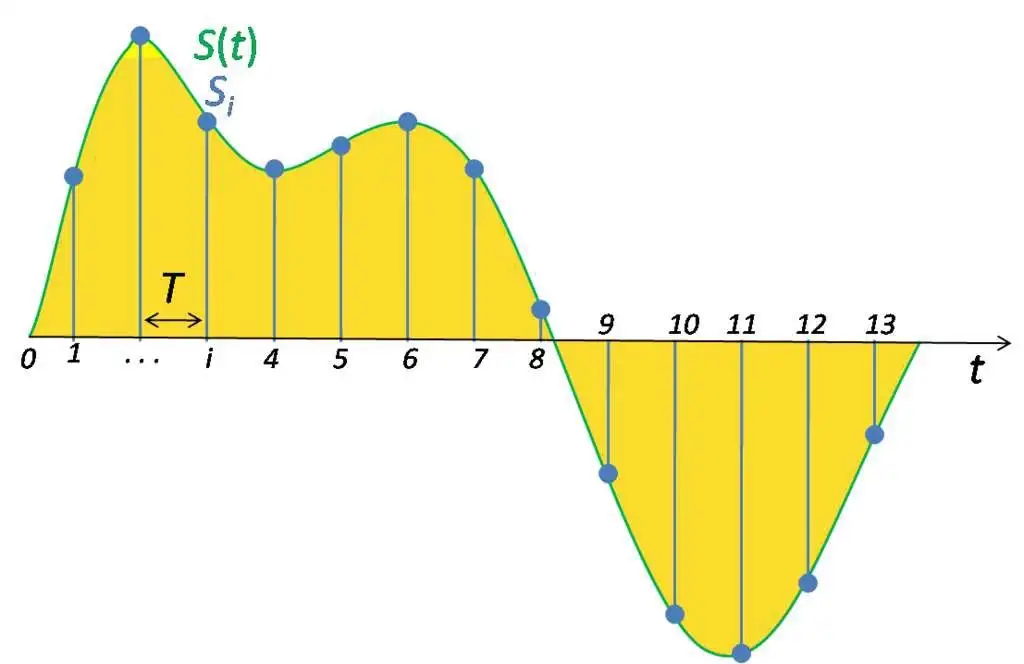


Each such measurement is called a sample, and the sample rate is the number of samples per second. For instance, a common sampling rate is about 44,100 samples per second. That means that a 10-second music clip would have 441,000 samples!
Let's see the average length in times of our dataset adn the mean of samples per audio.

In [ ]:
lengths = {}
for label in classes:
  print(f"-- Class {label} --")
  lengths[label] = []
  for file in os.listdir(path + label):
    tensor_wave = load_wav_16k_mono(os.path.join(path + label + "/" + file))
    lengths[label].append(len(tensor_wave))
  print(f"Average samples : {tf.math.reduce_mean(lengths[label])}")
  print(f"Min samples : {tf.math.reduce_min(lengths[label])}")
  print(f"Max samples : {tf.math.reduce_max(lengths[label])}")
  print(f"Number of audios : {len(lengths[label])}")

-- Class yes --
Average samples : 15766
Min samples : 8022
Max samples : 16000
-- Class no --
Average samples : 15708
Min samples : 7431
Max samples : 16000
-- Class up --
Average samples : 15652
Min samples : 7510
Max samples : 16000
-- Class stop --
Average samples : 15806
Min samples : 6688
Max samples : 16000
-- Class down --
Average samples : 15734
Min samples : 7510
Max samples : 16000
-- Class one --
Average samples : 15716
Min samples : 8192
Max samples : 16000
-- Class two --
Average samples : 15676
Min samples : 6827
Max samples : 16000
-- Class three --
Average samples : 15756
Min samples : 8875
Max samples : 16000
-- Class four --
Average samples : 15782
Min samples : 8192
Max samples : 16000
-- Class five --
Average samples : 15791
Min samples : 8174
Max samples : 16000
-- Class six --
Average samples : 15845
Min samples : 10240
Max samples : 16000
-- Class seven --
Average samples : 15756
Min samples : 5945
Max samples : 16000
-- Class eight --
Average samples : 15729
Min

### Waveform

A waveform plot is a visual representation of an audio signal that shows how the amplitude (loudness) of the signal changes over time. It is one of the most common ways to visualize audio data.

In a waveform plot, the horizontal axis represents time, usually measured in seconds, and the vertical axis represents the amplitude of the audio signal. The waveform plot displays the variations in the amplitude of the signal as a continuous line that moves up and down.

Typically, when the audio signal has higher amplitudes, the waveform will appear taller, indicating louder or more intense portions of the audio. Conversely, lower amplitudes will be represented by smaller heights in the waveform plot, indicating quieter sections.

By examining the waveform plot, you can get a sense of the overall structure of the audio signal, identify specific audio events or patterns, and observe characteristics such as the presence of silence, noise, or distinct audio segments.


### Spectrogram

Since a signal produces different sounds as it varies over time, its constituent frequencies also vary with time. In other words, its Spectrum varies with time.

A Spectrogram of a signal plots its Spectrum over time and is like a ‘photograph’ of the signal. It plots Time on the x-axis and Frequency on the y-axis. It is as though we took the Spectrum again and again at different instances in time, and then joined them all together into a single plot.

It uses different colors to indicate the Amplitude or strength of each frequency. The brighter the color the higher the energy of the signal. Each vertical ‘slice’ of the Spectrogram is essentially the Spectrum of the signal at that instant in time and shows how the signal strength is distributed in every frequency found in the signal at that instant.

Spectrograms are produced using Fourier Transforms to decompose any signal into its constituent frequencies.

### Visualiazing

Let's take a sample from every class and take a look at their waveform and spectrogram.

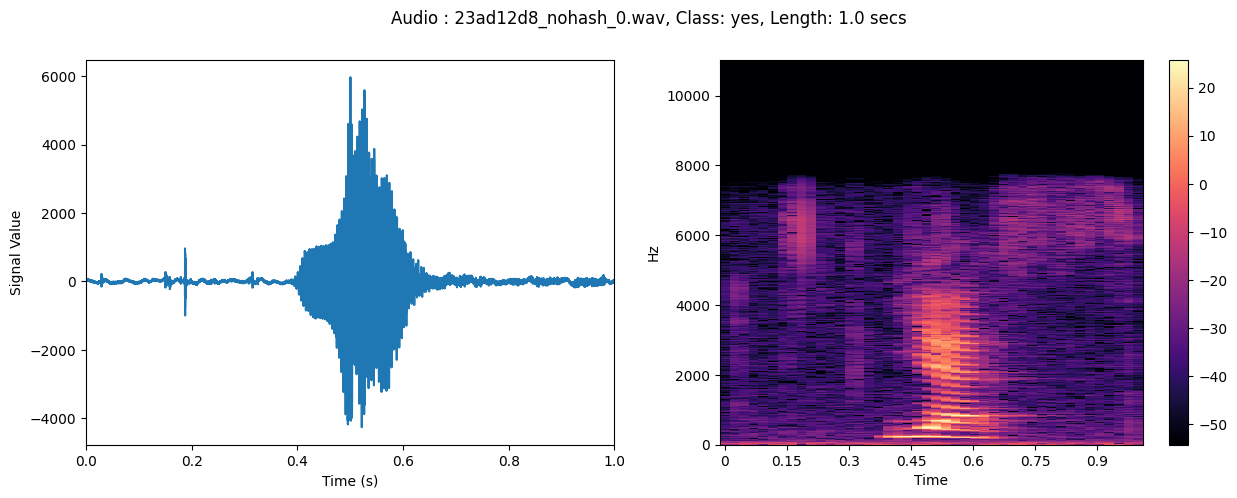

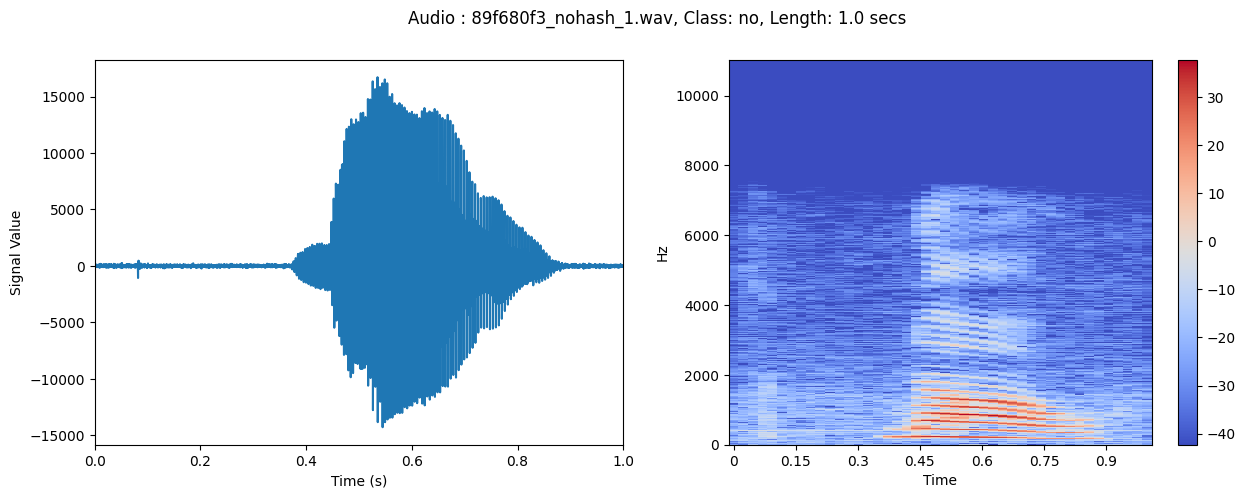

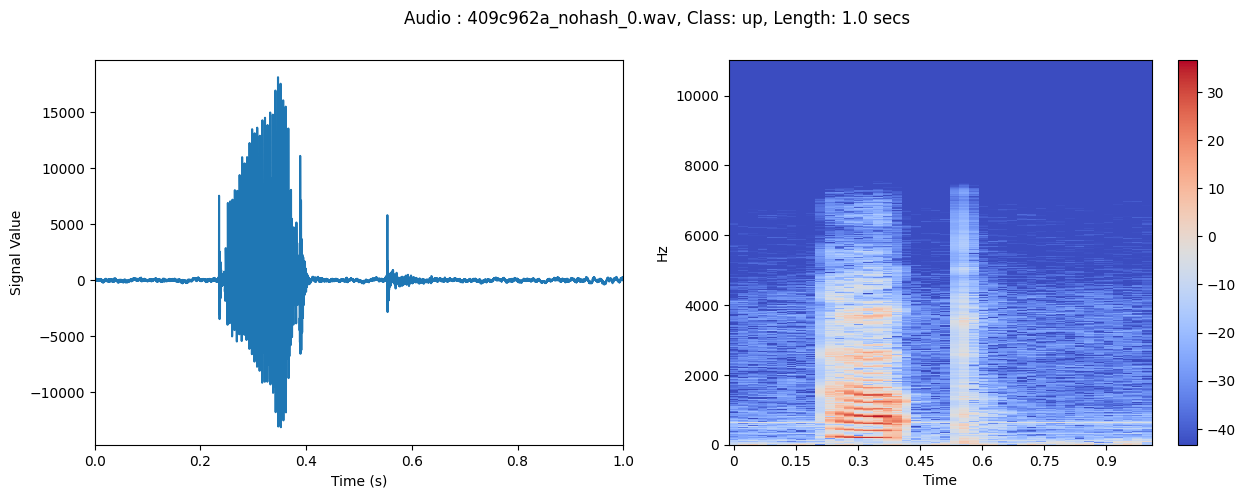

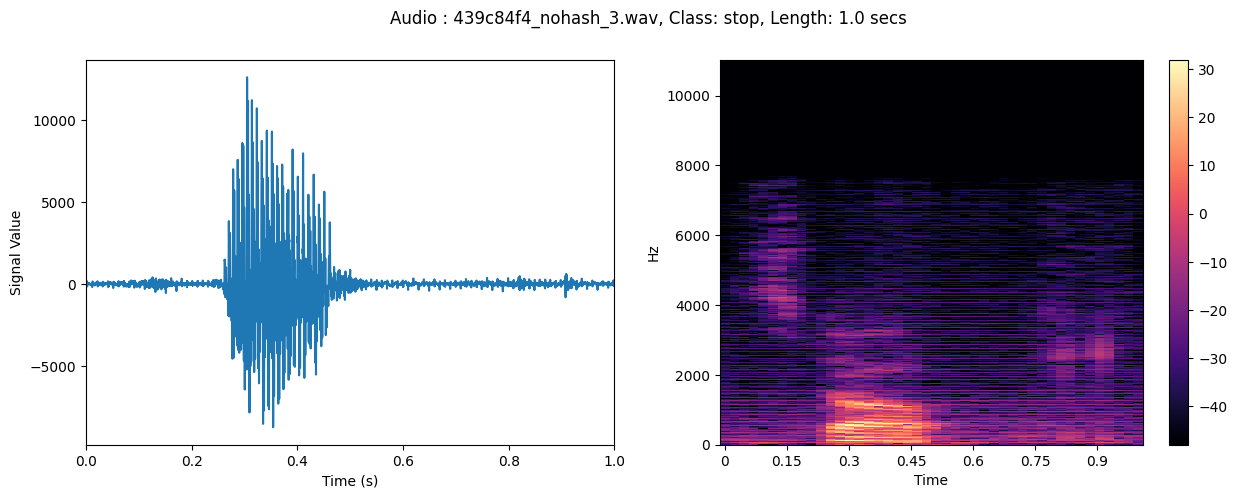

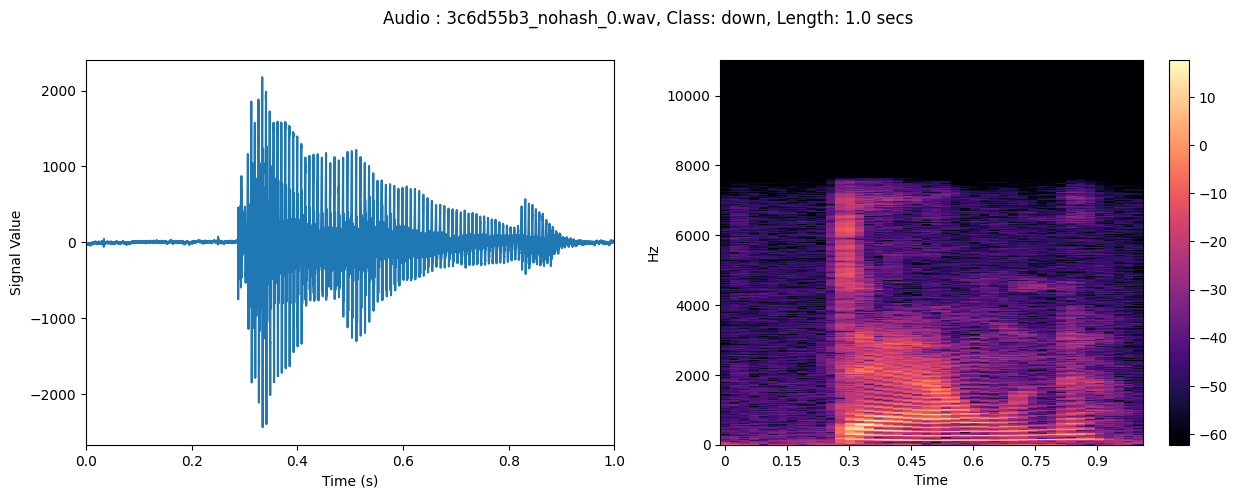

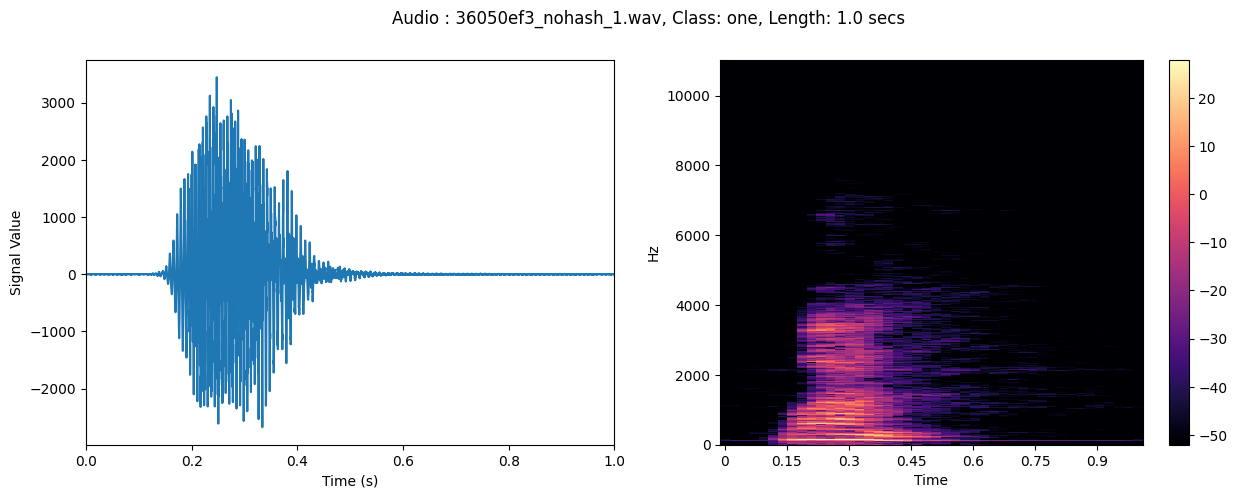

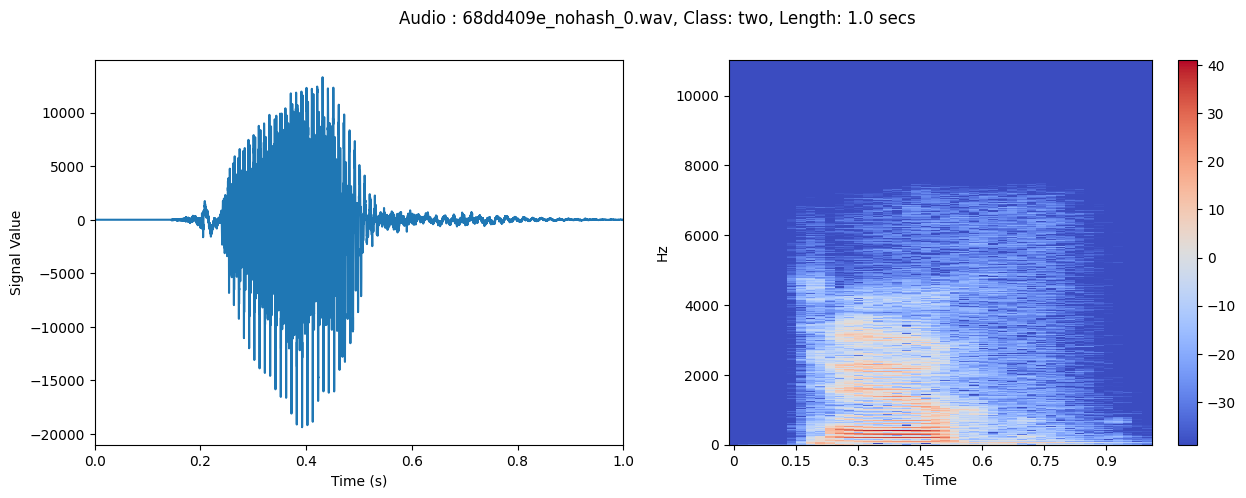

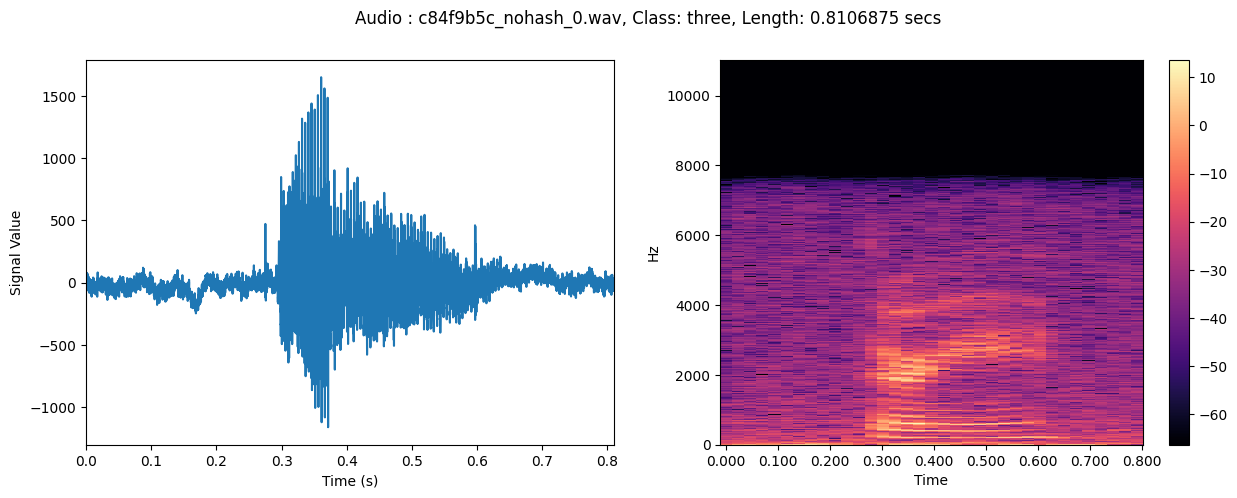

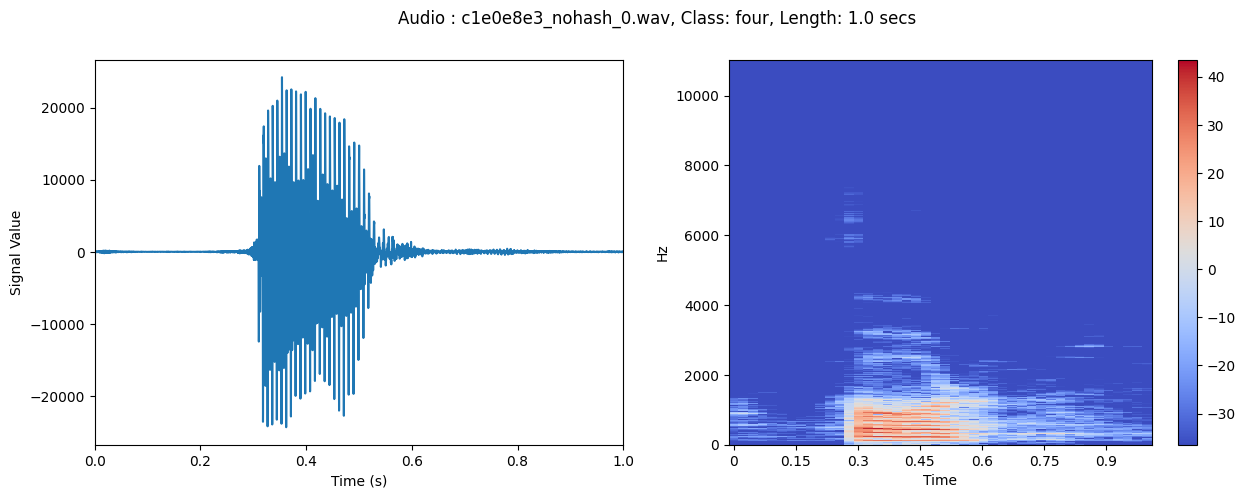

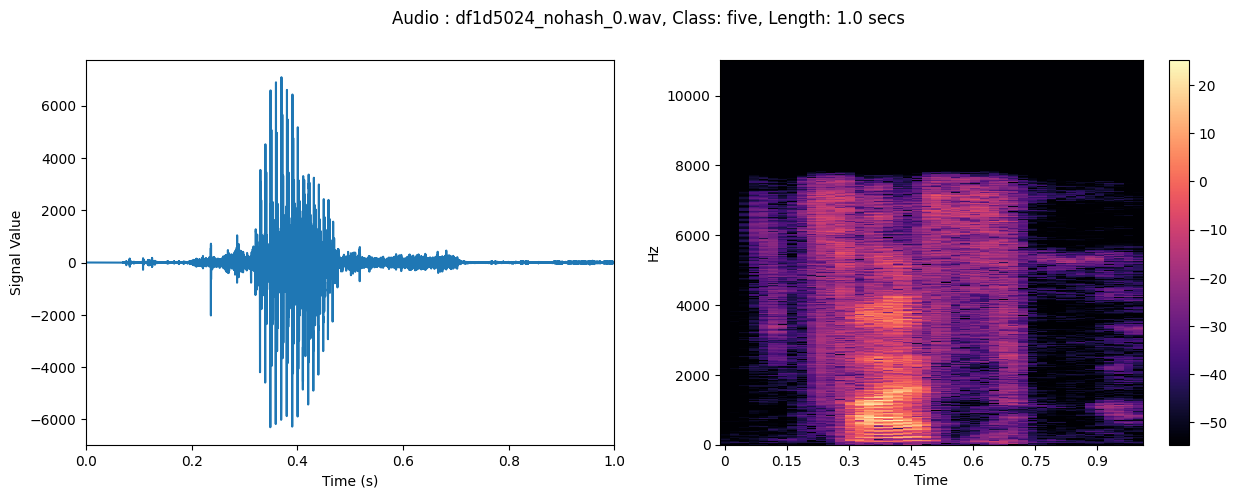

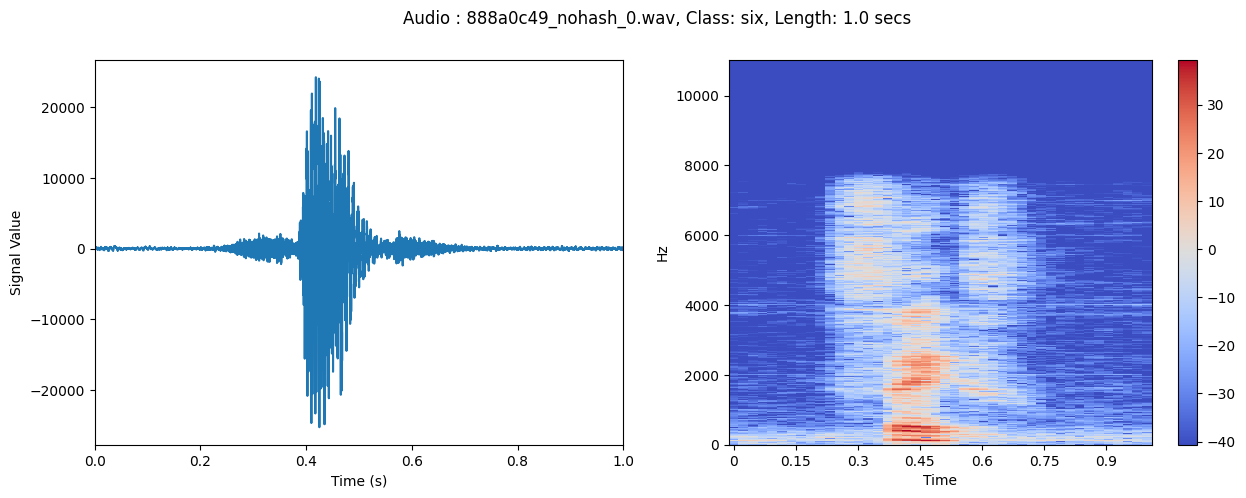

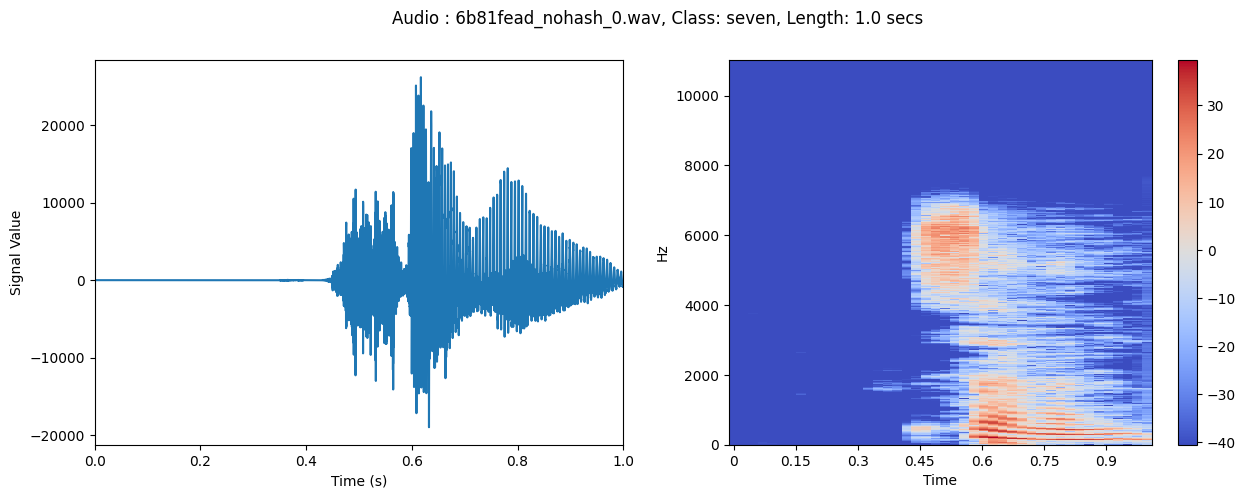

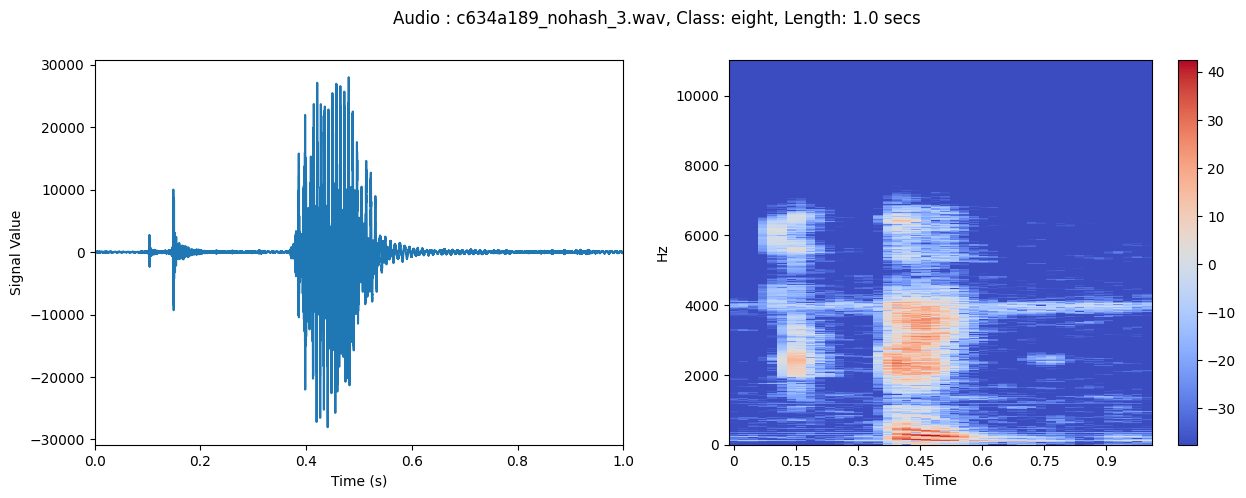

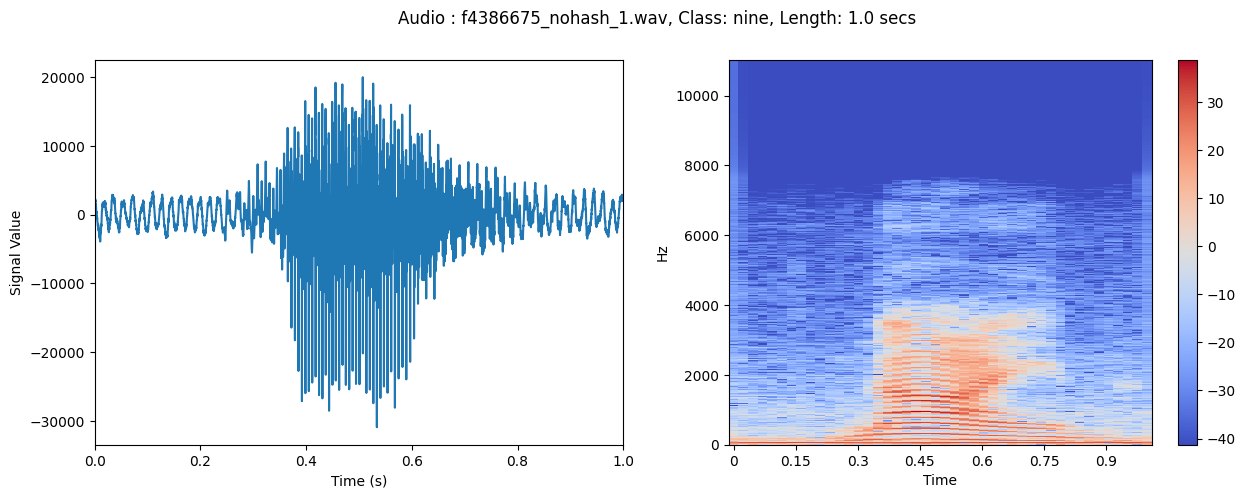

In [ ]:
def audioplot(path_class, n_samples=1):
    for _ in range(n_samples):
        # Build Wave form
        audio = random.choice(os.listdir(path_class))
        wav_obj = wave.open(path_class + "/" + audio, 'rb')
        sample_freq = wav_obj.getframerate()
        n_frames = wav_obj.getnframes()
        t_audio = n_frames/sample_freq  # time of the audio
        n_channels = wav_obj.getnchannels()
        signal_wave = wav_obj.readframes(n_frames)
        signal_array = np.frombuffer(signal_wave, dtype=np.int16)
        times = np.linspace(0, n_frames/sample_freq, num=n_frames)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(times, signal_array)
        ax1.set_ylabel('Signal Value')
        ax1.set_xlabel('Time (s)')
        ax1.set_xlim(0, t_audio)
        # Build spectrogram
        x, sr = librosa.load(path_class+"/"+audio)
        X = librosa.stft(x)
        Xdb = librosa.amplitude_to_db(abs(X))
        im = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax2)
        f.colorbar(im, ax=ax2)
        f.suptitle(f"Audio : {audio}, Class: {path_class.split('/')[-1]}, Length: {t_audio} secs")
        plt.show()

for label in classes:
  audioplot(path + label)

From the waveform above we can see that all our audio starts and ends with a silence period that can be see on the waveform by having low signal value.
Also, we can see differents pattern for every class. Meaning that an audio with label "seven" will have a different waveform than an audio with label "yes" for example.

Let's check if there is a pattern across each class, i.e. audio with labels "two" for example have similar waveform.

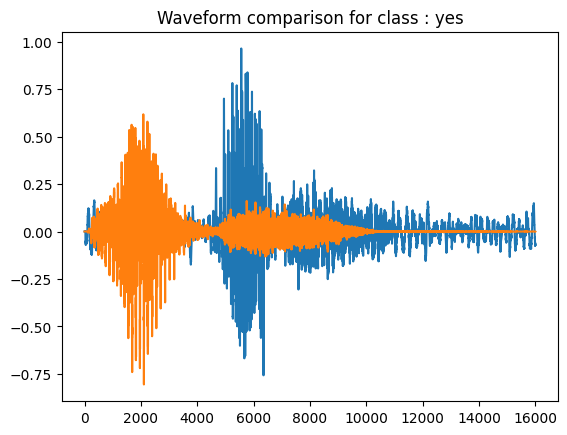

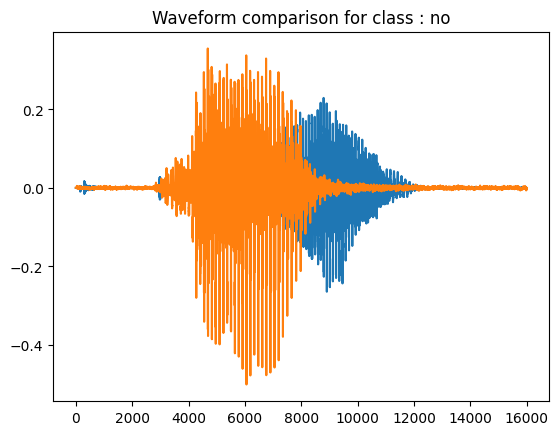

In [ ]:
def load_wav_16k_mono(filename):
  #load encoded wav file
  file_contents = tf.io.read_file(filename)
  #Decode wav
  wav, sample_rate  = tf.audio.decode_wav(file_contents, desired_channels = 1)
  #Removes trailing axis
  wav = tf.squeeze(wav, axis = -1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out = 16000)
  return wav

for label in classes[:2]:
  path_class = path + label + "/"
  audio_samples = [path_class + random.choice(os.listdir(path_class)) for _ in range(2)]
  plt.plot(load_wav_16k_mono(audio_samples[0]))
  plt.plot(load_wav_16k_mono(audio_samples[1]))
  plt.title(f"Waveform comparison for class : {label}")
  plt.show()

It seems that there is a pattern but a lot of noise makes it extremely unreadable. Let's try to use Mel-frequency Cepstral Coefficients (MFCC):

MFCC is a feature extraction technique widely used in speech and audio processing. It represents the power spectrum of the audio signal on a mel-scale, which approximates human perception of sound. MFCCs capture important spectral characteristics of the waveform, including both the shape of the spectral envelope and the temporal dynamics of the audio. By computing the MFCCs, you can extract patterns related to the spectral content and timbral characteristics of the waveform.

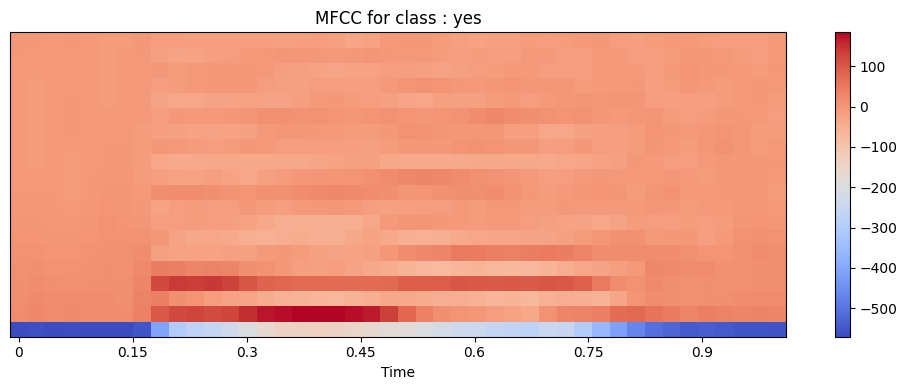

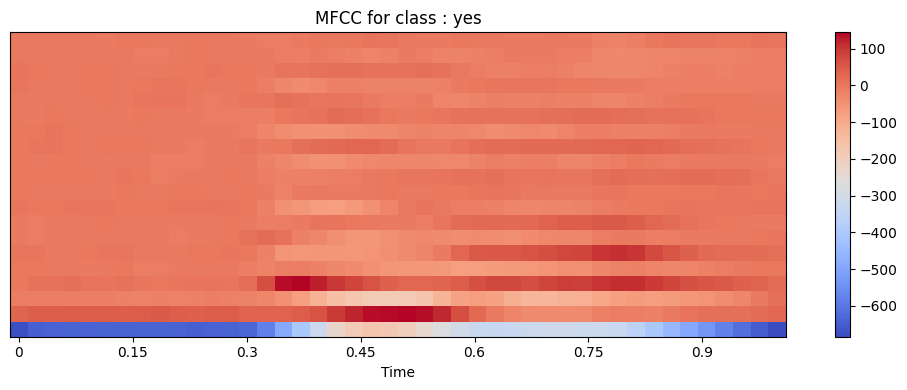

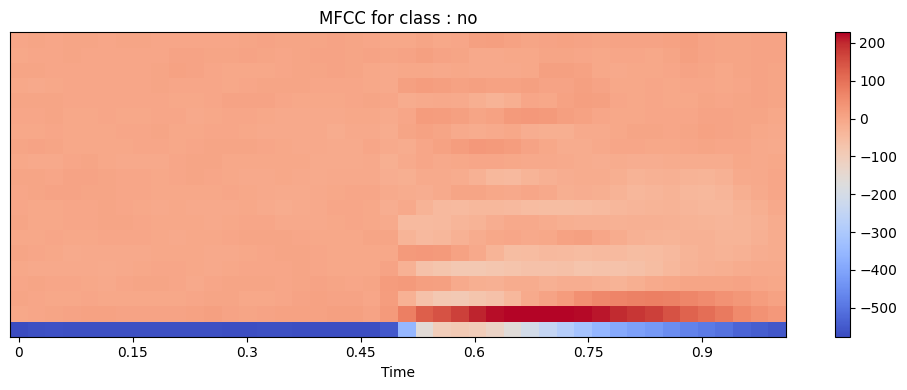

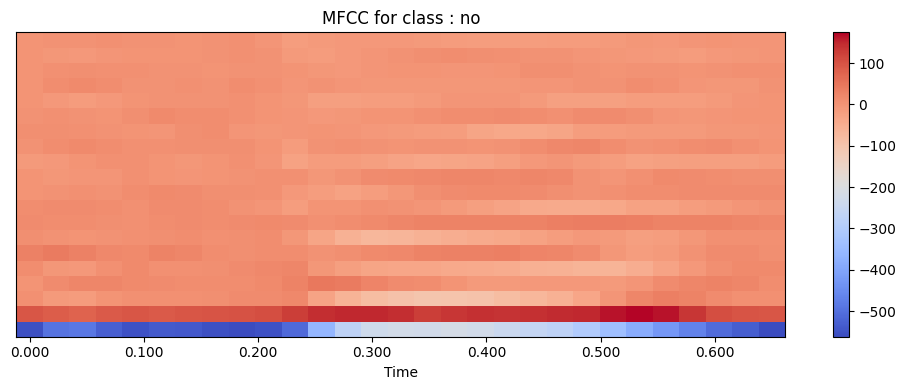

In [ ]:
for label in classes[:2]:
  path_class = path + label + "/"
  audio_samples = [path_class + random.choice(os.listdir(path_class)) for _ in range(2)]
  for i in range(2):
    x, sr = librosa.load(audio_samples[i])
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfccs, x_axis="time")
    plt.colorbar()
    plt.title(f'MFCC for class : {label}')
    plt.tight_layout()
    plt.show()

We can see that even though we have small difference in time we have a pattern for each class.

# Building dataset

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd ..
%cd content
%cd gdrive
%cd MyDrive
%cd speech_recognition

/
/content
/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/speech_recognition


In [6]:
tf_dic = {}
for i, label in enumerate(classes) :
  tmp = tf.data.Dataset.list_files(os.path.join(label, '*.wav')).take(500)
  tf_dic[label] = tf.data.Dataset.zip((tmp, tf.data.Dataset.from_tensor_slices(tf.fill((len(tmp),), i))))

datasets = list(tf_dic.values())

In [7]:
merged_dataset_loop = None
for dataset in datasets:
    if merged_dataset_loop is None:
        merged_dataset_loop = dataset
    else:
        merged_dataset_loop = merged_dataset_loop.concatenate(dataset)

In [8]:
merged_dataset_reduce = reduce(lambda d1, d2: d1.concatenate(d2), datasets)

In [9]:
dataset = merged_dataset_reduce.shuffle(buffer_size=1000)

# Preprocessing

In [10]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [11]:
def preprocess_multy(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, tf.one_hot(label, 13)

In [12]:
data = dataset.map(preprocess_multy)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [13]:
len(data)

407

In [14]:
# Create train / validation / test split
train = data.take(245)
val = data.skip(245).take(81)
test = data.skip(326).take(81)

In [15]:
samples, labels = train.as_numpy_iterator().next()
samples.shape, labels.shape

((16, 491, 257, 1), (16, 13))

# Baseline Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
base_model = Sequential()
base_model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257,1)))
base_model.add(Flatten())
base_model.add(Dense(13, activation='softmax'))

In [ ]:
base_model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
base_model.summary()

In [ ]:
hist = base_model.fit(train, validation_data=val, epochs=10)

In [ ]:
base_model.save('/content/gdrive/MyDrive/speech_recognition/baseline_10')

In [17]:
from keras.models import load_model

base_model_loaded = load_model('/content/gdrive/MyDrive/speech_recognition/baseline_10')

In [18]:
base_model_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 489, 255, 16)      160       
                                                                 
 flatten_2 (Flatten)         (None, 1995120)           0         
                                                                 
 dense_2 (Dense)             (None, 13)                25936573  
                                                                 
Total params: 25,936,733
Trainable params: 25,936,733
Non-trainable params: 0
_________________________________________________________________


In [19]:
from sklearn.metrics import classification_report

In [20]:
# Create empty arrays/lists for true labels and predicted labels
y_true = []
y_pred = []

# Iterate over the test dataset and make predictions
for x, y in test:
    # Predict the labels using the loaded trained model
    predictions = base_model_loaded.predict(x)
    predicted_labels = np.argmax(predictions, axis=1)

    # Store the true labels and predicted labels
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(predicted_labels)

# Convert the true labels and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred)

print(report)

1/1 [==============================] - 0s 176ms/step
              precision    recall  f1-score   support

           0       0.21      0.30      0.25        10
           1       0.07      0.67      0.12         6
           2       0.10      0.75      0.18         8
           3       0.26      0.80      0.39        10
           4       0.65      0.96      0.77        23
           5       0.49      0.97      0.65        34
           6       0.25      0.83      0.38        52
           7       0.87      0.79      0.83        67
           8       0.86      0.76      0.81        92
           9       0.94      0.88      0.91       148
          10       0.77      0.70      0.73       191
          11       0.90      0.56      0.69       282
          12       0.97      0.57      0.72       361

    accuracy                           0.68      1284
   macro avg       0.56      0.73      0.57      1284
weighted avg       0.84      0.68      0.72      1284



THe results above are better than in the report because I had to re-run the notebook and the new split is different (so, there are previous train & validation batches in the new test)

In [21]:
X_test, y_test = test.as_numpy_iterator().next()
y_pred = base_model_loaded.predict(X_test)

1/1 [==============================] - 0s 432ms/step


In [22]:
word_labels = ['yes', 'no', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'up', 'down']

test_labels = list(np.argmax(y_test, axis=1))
predicted_labels = list(np.argmax(y_pred, axis=1))

y_test_label = np.array([word_labels[i] for i in test_labels])
y_pred_label = np.array([word_labels[i] for i in predicted_labels])

print(f'True labels:\n {y_test_label}, \nPredicted labels: \n {y_pred_label}')
print(f'We got {np.sum(y_test_label ==y_pred_label)} out of {len(test_labels)} items right!')

True labels:
 ['seven' 'one' 'four' 'yes' 'eight' 'up' 'three' 'six' 'down' 'eight' 'up'
 'down' 'down' 'down' 'down' 'six'], 
Predicted labels: 
 ['seven' 'one' 'four' 'seven' 'eight' 'up' 'three' 'six' 'down' 'eight'
 'up' 'down' 'down' 'nine' 'nine' 'six']
We got 13 out of 16 items right!
